<a href="https://colab.research.google.com/github/pranshumalik14/ece421-labs-hw/blob/main/labs/lab2/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Neural Networks

In this lab, we will be creating a neural network from scratch using NumPy.

## 1. Neural Networks using Numpy

We will consider the usual (but limited) defintion of a neural network as a sequence of fully-connected (or dense) layers consisting of nodes with independent activations, except for possibly the output layer where we may have require a multiclass probability distribution as the output or some similarly inferrable vector; we will exclusively consider this case in the lab to classify the `notMNIST` dataset across all 10 alphabets.

We will begin by defining classes for the three central components of any neural network:

1.   Layers which are assumed to be linear here and are characterized by the number of nodes
2.   Activation functions that produce the output at any particular layer
3.   Output loss Function that is minimized using gradient descent

### 1.1 Helper Functions, Network Definitions, and Initialization

In [2]:
import numpy as np
import matplotlib.pyplot as plt

We first start with defining the activation functions along with their derivatives, which we will later be able to use in our neural networks during gradient descent (the learning phase).

In [3]:
# activation functions
class ReLU:
    # relu = max(x, 0)    
    @staticmethod
    def __call__(x):
        return np.maximum(x, 0)
    # derivative of relu
    @staticmethod
    def prime(x):
        return np.where(x > 0.0, 1.0, 0.0)

class Softmax:
    # softmax = exp(xi)/sum(exp(xj)), applied row-wise to match data
    @staticmethod
    def __call__(x):
        # subtract maximum for numerical stability
        # while keeping the relative differences intact
        exp = np.exp(x - x.max(axis=1, keepdims=True))
        return exp/exp.sum(axis=1, keepdims=True)

    # we can not use this method for batch processing since it 
    # returns the full Jacobian and will be incompatible with
    # element-wise products
    @staticmethod
    def prime(x): # x should be a vector, flat
        assert len(x) == 1 or len(x.T) == 1
        s = Softmax()(x)
        return np.diag(s) - np.outer(s, s)

# just as an extension of the lab
class Sigmoid:
    # sigmoid = 1 / (1 + exp(-x))
    @staticmethod
    def __call__(x):
        return 1/(1 + np.exp(-x))
    # derivative of sigmoid
    @staticmethod
    def prime(x):
        sigmoid = Sigmoid()(x)
        return sigmoid*(1 - sigmoid)

Now, we define the `Network` class that will be used to define an arbitrary network with dense (fully-connected) layers. The class definition and functionality will expand as we progress through each section. We begin with defining the functions that create the network structure, model parameters, their initialization, and the forward pass through the network.

Particularly, in our implementation, we consider the layers ranging from $0\le l\le L$ where layer $L$ denotes the output layer and $0$ denotes the input layer. The weights weight $w^{(l)}_{i,j}$ along an edge connecting node $i$ in layer $l-1$ to node $j$ in layer $l$ is considered to be a part of the weight matrix $\mathbf{W}^{(l)}$ in the conventional row-column indexing. We utilize the Xavier scheme to initialize the weights, where specifically 
$$w^{(l)}_{i,j} \sim \mathcal{N}\left(0, \frac{1}{\frac{n_{\text{in}} + n_{\text{out}}}{2}}\right) \quad \text{ for } 1\le l\le L,$$
where $n_{\text{in}}$ and $n_{\text{out}}$ are the number of nodes in the previous layer and number of nodes in the next layer (if any), respectively. Similarly, the biases $\mathbf{b}^{(l)}$ specify the bias for the summation at each node in layer $l$, and they are initialized to zero according to the Xavier scheme.

In [4]:
class Network:
    def __init__(self, layer_sizes, layer_activations):
        assert len(layer_activations) == len(layer_sizes)-1
        self.sizes   = layer_sizes
        self.thetas  = layer_activations

        # xavier init scheme
        n_out = layer_sizes[1:] + [0]
        n_in  = [0] + layer_sizes[:-1]
        self.biases  = [np.zeros((1, n)) for n in layer_sizes[1:]] # row-vecs
        self.weights = [np.random.randn(m,n)/np.sqrt((n_out[i]+n_in[i])/2) for 
                        i, (m, n) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:]))]

    def fwd_prop(self, X):
        X_ell = X   # X_0 (input layer)
        for W, b, theta in zip(self.weights, self.biases, self.thetas):
            X_ell = theta((X_ell @ W) + b) # compute X_l, 0 < l <= L
        return X_ell # X_L (output layer)

We will now define the loss function that we will use to train our model, along with the accuracy model. Like lab 1, we will use the cross entropy loss since it is based on achieving the maximum likelihood estimate of all the target labels, which are assumed to be mutually exlusive, and is therefore fit for the classification task at hand. It is defined as:

$$E_{\text{in}}(\Omega) =  -\sum_{n=1}^N \mathbf{y}_n\log\left(\widehat{\mathbf{p}}_n\right)^\top$$

where the row vectors $\widehat{\mathbf{p}}_n$ and $\mathbf{y}_n$ are the predicted distribution and target (one-hot) label for the $n^{\text{th}}$ out of $N$ samples in our training dataset, and $\Omega$ is the set of trainable model parameters (weights and biases) in our network.

In [5]:
# loss function
class CrossEntropy:
    @staticmethod
    def __call__(p_hat, ys):
        return -np.sum(ys*np.log(p_hat))

    # derivative with respect to input (prediction distributions)
    @staticmethod
    def derivative(p_hat, ys):
        return -ys/p_hat

    # gradient with respect to s^(3), the input to softmax layer
    @staticmethod
    def grad_softmaxlogits(logits, ys):
        return Softmax()(logits) - ys # p_hat - ys

The `accuracy` function is defined below to compute the mean number of misclassifications, giving us an idea of how likely it is for the network to arrive at an incorrect label.

In [6]:
# accuracy of prediction
def accuracy(p_hat, ys):
    return np.mean(np.argmax(ys, axis=1) == np.argmax(p_hat, axis=1))

We will run a forward pass on an untrained, newly initialized, network and test for its accuracy to make sure our implementation is functional thus far. We source the data from section 1.3 just for this purpose.

In [13]:
# create neural network
F, H, K = 784, 1000, 10
nn = Network([F, H, K], [ReLU(), Softmax()])

# forward pass, loss, and accuracy on random init
p_hat    = nn.fwd_prop(X_train)
accur    = accuracy(p_hat, ys_train)
avg_loss = CrossEntropy()(p_hat, ys_train)/X_train.shape[0]
print("Loss = {}, Accuracy = {}".format(avg_loss, accur))

Loss = 2.5505140785532827, Accuracy = 0.0908


### 1.2 Backpropagation Derivation

We implement and use the backpropagation algorithm to be able to efficiently perform gradient descent to minimize the loss.

Particularly, we will be considering a 3-layer network as defined above in section 1.1. We explicitly derive the gradient of the loss function with respect to the model parameters, to be able to update them. The four gradients we need to compute are: $\frac{\partial E_{\text{in}}}{\partial \mathbf{W}^{(2)}}$, $\frac{\partial E_{\text{in}}}{\partial \mathbf{b}^{(2)}}$, $\frac{\partial E_{\text{in}}}{\partial \mathbf{W}^{(1)}}$, and $\frac{\partial E_{\text{in}}}{\partial \mathbf{b}^{(1)}}$.

Before we start, we have some preliminaries:
* At each layer, $\mathbf{s}_n^{(l)}, \mathbf{x}_n^{(l)}\in \mathbb{R}^{d^{(l)}}$ are the (pre-activation) summation and the activation output vectors. The vector $\mathbf{x}^{(0)}\in\mathbb{R}^{d^{(0)}}$ is the input feature vector, i.e. a flattened image in our case. The summation is given by $\mathbf{s}_n^{(l)} = \mathbf{W}^{(l)\top}\mathbf{x}^{(l-1)}_n + \mathbf{b}^{(l)}$ and the corresponding layer activation is $\mathbf{x}_n^{(l)} = \boldsymbol{\theta}^{(l)}(\mathbf{s}^{(l)})$, where $\boldsymbol{\theta}^{(l)}$ is the layer activation function, which in our case be almost exclusively be a scalar-valued function that is applied element-wise to the input vector.
* The derivative of the (single-sample) loss function with respect to the summation at a particular layer, i.e. $\frac{\partial e_n}{\partial \mathbf{s}^{(l)}}$, is denoted as $\delta_n^{(l)}$. In the batch-sample case, it is simply a matrix with the respective dimensions to consider each input data vector.
* The backpropagation gradient rule for $1 \le l < L$ (considering the single vector sample case) is $\delta^{(l)}_n = \mathbf{W}^{(l+1)}\delta^{(l+1)}_n \odot \boldsymbol{\theta}^{(l)\prime}(\mathbf{s}^{(l)}) \in \mathbb{R}^{d^{(l)}}$ for any $n^{\text{th}}$ sample in the dataset, where $\boldsymbol{\theta}^{(l)\prime}$ is the derivative of the (scalar) activation function with respect to its input which is the summation at that layer, $\odot$ is the element-wise product, and the gradient of the sample loss with respect to the weights at layer $l$ is given by $\frac{\partial e_n}{\partial w_{i,j}^{(l)}} = x_{n, i}^{(l-1)}\delta_{n, j}^{(l)}$.
* Note that we calculate $\boldsymbol{\delta}^{(L=2)}$ directly in our implementation of the loss function, where we have already included it as the `CrossEntropy.grad_softmaxlogits` member function that returns the derivative of cross-entropy loss (considering one-hot encoded targets) with respect to $\mathbf{S}^{(2)}$. This can be shown to be $\boldsymbol{\delta}^{(2)} = \frac{\partial E_{\text{in}}}{\partial \mathbf{S}^{(2)}} =  \mathbf{X}^{(2)}- \mathbf{Y} \in \mathbb{R}^{N\times d^{(2)}}$.

Now, we derive the gradients for each model parameter (weights/biases) matrix.

* We can write $\frac{\partial E_{\text{in}}}{\partial \mathbf{W}^{(2)}} = \mathbf{X}^{(1)\top}\boldsymbol{\delta}^{(2)} \in \mathbb{R}^{d^{(1)}\times d^{(2)}}$. This is akin to the single activation input case where $\frac{\partial e_n}{\partial \mathbf{W}^{(2)}} = \mathbf{x}_n^{(2)}\delta^{(2)\top}_n$. But in the batch case, $\delta_n^{(2)}$ being a flat vector per input, multiplying this way gives us the summed version of the respective sample-loss gradients with respect to the weight matrix, which is what we desire.
* The gradient $\frac{\partial E_{\text{in}}}{\partial \mathbf{b}^{(2)}} = \frac{\partial E_{\text{in}}}{\partial \mathbf{S}^{(2)}}\frac{\partial \mathbf{S}^{(2)}}{\partial \mathbf{b}^{(2)}} = \mathbf{1}^{\top}\boldsymbol{\delta}^{(2)} \in \mathbb{R}^{1\times d^{(2)}}$, where recall that $\mathbf{S}^{(2)} = \mathbf{X}^{(1)\top}\mathbf{W}^{(2)}+ \mathbf{b}^{(2)}$. Particularly, we can notice that $\boldsymbol{\delta}^{(2)} \in \mathbb{R}^{N\times d^{(2)}}$ contains the bias derivatives per sample in each row for which this multiplication with ones that are transposed has a summing effect. This may also be written as $\sum_{n=1}^{N}\delta_n^{(2)}$, where simply reduce the matrix to a vector by a row-wise sum denoting the total gradient across all (independent) samples.
* We get $\frac{\partial E_{\text{in}}}{\partial \mathbf{W}^{(1)}} = \mathbf{X}^{(0)\top}\boldsymbol{\delta}^{(1)} \in \mathbb{R}^{d^{(0)}\times d^{(1)}}$, where $\boldsymbol{\delta}^{(1)} = \boldsymbol{\delta}^{(2)} \mathbf{W}^{(2)\top} \odot \boldsymbol{\theta}^\prime(\mathbf{S}^{(1)}) \in \mathbb{R}^{N\times d^{(1)}}$, which we get while following the backpropagation rule and adhering to the dimensional constriants, such that the $\delta^{(1)}_n$ row-vector for each summation sample $\mathbf{s}^{(1)}_n$ can be tiled for later being accumulated over all samples while calculating the gradient with respect to weights. Therefore, a similar case can be made as $∇_{\mathbf{W^{(2)}}}E_{\text{in}}$ to interpret the matrix derivatives over batches.
* And lastly $\frac{\partial E_{\text{in}}}{\partial \mathbf{b}^{(1)}} = \mathbf{1}^\top\boldsymbol{\delta}^{(1)} \in \mathbb{R}^{1\times d^{(1)}}$, which follows from the derivation for $∇_{\mathbf{b}^{(2)}}E_{\text{in}}$ above.

In [8]:
# due to time-availability constraints, we will constrain training to an L-layer
# network with softmax output activation and cross entropy loss, i.e. not generic
def multiclass_CE_back_prop(self, X, ys, loss):
    assert isinstance(self.thetas[-1], Softmax)
    assert isinstance(loss, CrossEntropy)
    # also, we can not support vector activation functions (like softmax) in 
    # middle layers (and at the input)
    for i in range(len(self.thetas)-1):
        assert not isinstance(self.thetas[i], Softmax)

    # get summations and activations
    X_ells = [X]
    S_ells = []
    for W, b, theta in zip(self.weights, self.biases, self.thetas):
        S_ell = (X_ells[-1] @ W) + b
        X_ells.append(theta(S_ell))
        S_ells.append(S_ell)
    
    # create list of gradients (intended to be used in increasing order of layers)
    grad_biases  = len(self.biases)*[None]
    grad_weights = len(self.weights)*[None]

    # backprop:
    # start from ell = L (the softmax output layer)
    # delta_L = loss.derivative(X_ells[-1], ys)*self.thetas[-1].prime(S_ells[-1])
    delta_ell = loss.grad_softmaxlogits(S_ells[-1], ys)
    grad_biases[-1]  = delta_ell.sum(axis=0)
    grad_weights[-1] = X_ells[-2].T @ delta_ell

    # continue backwards (1 < ell < L)
    for l in range(2, len(self.sizes)):
        delta_ell = delta_ell @ self.weights[-l+1].T * self.thetas[-l].prime(S_ells[-l])
        grad_biases[-l]  = delta_ell.sum(axis=0)
        grad_weights[-l] = X_ells[-l-1].T @ delta_ell

    return grad_weights, grad_biases

# run batch backprop over a generic (fully-connected) network with vector-valued
# activations too; for inspiration see: https://sgugger.github.io/a-simple-neural-net-in-numpy.html
def back_prop(self, X, ys):
    raise NotImplementedError # todo: for future me
    return grad_weights, grad_biases

# expand Network definition
Network.back_prop = multiclass_CE_back_prop # todo: generic back_prop

### 1.3 Learning

With the backpropagation set up, we can now start training our network. Below, we load our data and tranform it (flattening and one-hot encoding) to be compatible with our formulation.

In [9]:
# data loader and associated helper functions
def loadDataGDrive():
    with np.load('/content/drive/MyDrive/Colab Notebooks/notMNIST.npz') as data:
        data, targets = data["images"], data["labels"]
        
        np.random.seed(521)
        rand_idx = np.arange(len(data))
        np.random.shuffle(rand_idx)
        
        data = data[rand_idx] / 255.0
        targets = targets[rand_idx].astype(int)
        
        train_data, train_target = data[:10000], targets[:10000]
        valid_data, valid_target = data[10000:16000], targets[10000:16000]
        test_data, test_target = data[16000:], targets[16000:]
        train_target, valid_target, test_target = convert_onehot(train_target, 
                                                                 valid_target, 
                                                                 test_target)
    return train_data, valid_data, test_data, train_target, valid_target, test_target

def convert_onehot(train_target, valid_target, test_target):
    new_train = np.zeros((train_target.shape[0], 10))
    new_valid = np.zeros((valid_target.shape[0], 10))
    new_test = np.zeros((test_target.shape[0], 10))

    for item in range(0, train_target.shape[0]):
        new_train[item][train_target[item]] = 1
    for item in range(0, valid_target.shape[0]):
        new_valid[item][valid_target[item]] = 1
    for item in range(0, test_target.shape[0]):
        new_test[item][test_target[item]] = 1
    return new_train, new_valid, new_test

# load data
x_train, x_valid, x_test, ys_train, ys_valid, ys_test = loadDataGDrive()

In [10]:
# flatten datavectors
X_train = x_train.reshape(x_train.shape[0], -1)
X_valid = x_valid.reshape(x_valid.shape[0], -1)
X_test  = x_test.reshape(x_test.shape[0], -1)

# data for training and testing our neural network
Xs = np.array([X_train, X_valid, X_test], dtype=object)    # training, validation, and testing data
Ys = np.array([ys_train, ys_valid, ys_test], dtype=object) # training, validation, and testing labels

In [11]:
def plot_learning_history(title, loss_hist, acc_hist):
    # loss_hist = [train_loss, valid_loss, test_loss]
    # acc_hist  = [train_acc, valid_acc, test_acc]
    f, ax  = plt.subplots(1, 2, figsize=(8,4))
    labels = ["Train", "Validation", "Test"]

    for i in range(loss_hist.shape[1]):
        ax[0].plot(loss_hist[:, i], label=labels[i]) # plot loss history on left
        ax[1].plot(acc_hist[:, i], label=labels[i])  # plot accuracy history on right
    
    # add lables and title
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    f.suptitle(title, fontsize=14, y=1.03)
    return plt.tight_layout()

The gradients that are computed using backpropagation will be applied to the respective parameters with memory, i.e. there will be an influence of past gradients on current update as well. This is called momentum-based updates. Specifically, we will use the following update equations:

$$\begin{align*}
\boldsymbol{\nu}_{k+1} &= \gamma\boldsymbol{\nu}_{k} + \alpha\left(\frac{\partial E_{\text{in}}}{\partial \mathbf{W}}\right)_k\\
\mathbf{W}_{k+1} &= \mathbf{W}_{k} - \boldsymbol{\nu}_{k+1}
\end{align*},$$

where $\alpha>0$ is the learning rate, $\gamma>0$ is the momentum factor, and $k$ is the iteration or epoch number. This will be done for all the weight and bias terms independently of each other.

In [12]:
def apply_gradients(self, grad_weights, grad_biases, alpha_scaling=1):
    alpha = self.alpha/alpha_scaling
    gamma = self.gamma

    # update momemtums
    self.bias_momentums   = [gamma*V + alpha*W for V, W in zip(self.bias_momentums, grad_biases)]
    self.weight_momentums = [gamma*V + alpha*W for V, W in zip(self.weight_momentums, grad_weights)]
    
    # update weights and biases
    self.biases  = [W - V for W, V in zip(self.biases, self.bias_momentums)]
    self.weights = [W - V for W, V in zip(self.weights, self.weight_momentums)]

# expand Network definition
Network.apply_gradients = apply_gradients

We now write the generic training loop for our network.

In [14]:
def train(self, Xs, Ys, loss, accuracy, epochs, alpha=0.1, gamma=0.9, initvel=1e-5):
    # Xs = [X_train, X_valid (optional), X_test (optional)]
    # Ys = [ys_train, ys_valid (optional), ys_test (optional)]
    loss_hist = np.empty((0,Xs.shape[0]), float)
    acc_hist  = np.empty((0,Xs.shape[0]), float)

    # initialize momentums
    self.alpha = alpha
    self.gamma = gamma
    self.bias_momentums   = [np.full((1, n), initvel) for n in self.sizes[1:]]
    self.weight_momentums = [np.full((m, n), initvel) for m, n in 
                             zip(self.sizes[:-1], self.sizes[1:])]

    for epoch in range(epochs):
        # apply gradient descent
        grad_weights, grad_biases = self.back_prop(Xs[0], Ys[0], loss)
        self.apply_gradients(grad_weights, grad_biases, alpha_scaling=Xs[0].shape[0])

        # compute current loss and accuracy
        outputs   = [self.fwd_prop(Xs[i]) for i in range(Xs.shape[0])]
        loss_hist = np.append(loss_hist, [[loss(outputs[i], Ys[i])/Xs[i].shape[0] for i in range(Xs.shape[0])]], axis=0)
        acc_hist  = np.append(acc_hist, [[accuracy(outputs[i], Ys[i]) for i in range(Xs.shape[0])]], axis=0)

        # print progress
        if epoch % 20 == 0:
            print(f"Epoch {epoch} | Training Loss: {loss_hist[-1, 0]} Training Accuracy: {acc_hist[-1, 0]}")

    return self.weights, self.biases, loss_hist, acc_hist

# expand Network defintion
Network.train = train

Below, we train the requested 3-layer network and also try a 4-layer network with an extra hidden layer with `Sigmoid` activation.

In [55]:
# recreate network (due to updates to class definition) and train on data
nn = Network([F, H, K], [ReLU(), Softmax()])
_, _, three_lyr_loss_hist, three_lyr_accuracy_hist = nn.train(Xs, Ys, CrossEntropy(), accuracy, 200)

Epoch 0 | Training Loss: 2.375626022023701 Training Accuracy: 0.2665
Epoch 20 | Training Loss: 0.4207333231947012 Training Accuracy: 0.8865
Epoch 40 | Training Loss: 0.30412885450972155 Training Accuracy: 0.9132
Epoch 60 | Training Loss: 0.2538062655623269 Training Accuracy: 0.9288
Epoch 80 | Training Loss: 0.21788812767121782 Training Accuracy: 0.9398
Epoch 100 | Training Loss: 0.1891358401826244 Training Accuracy: 0.9486
Epoch 120 | Training Loss: 0.1647921682497029 Training Accuracy: 0.9579
Epoch 140 | Training Loss: 0.14381952617954716 Training Accuracy: 0.9649
Epoch 160 | Training Loss: 0.12557783392061336 Training Accuracy: 0.972
Epoch 180 | Training Loss: 0.10972784637818538 Training Accuracy: 0.9782


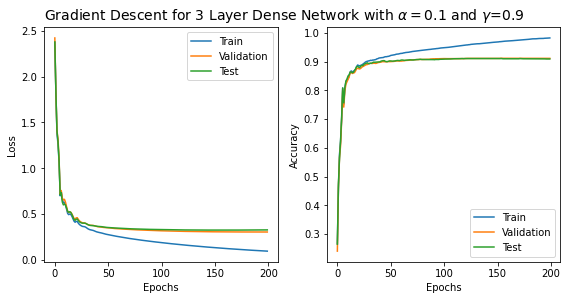

In [56]:
title = r"Gradient Descent for 3 Layer Dense Network with $\alpha={}$ and $\gamma$={}".format(0.1, 0.9)
plot_learning_history(title, three_lyr_loss_hist, three_lyr_accuracy_hist)

In [21]:
# define a 4 layer network with an additional sigmoid layer to the previous network
nn = Network([F, H, H, K], [ReLU(), Sigmoid(), Softmax()])
_, _, four_lyr_loss_hist, four_lyr_accuracy_hist = nn.train(Xs, Ys, CrossEntropy(), accuracy, 200, alpha=0.05, gamma=0.90)

Epoch 0 | Training Loss: 2.2934281028063777 Training Accuracy: 0.1247
Epoch 20 | Training Loss: 0.6611879141116863 Training Accuracy: 0.8468
Epoch 40 | Training Loss: 0.4645522713631396 Training Accuracy: 0.8761
Epoch 60 | Training Loss: 0.41121610429342925 Training Accuracy: 0.8882
Epoch 80 | Training Loss: 0.38075533495829833 Training Accuracy: 0.8971
Epoch 100 | Training Loss: 0.359367611759736 Training Accuracy: 0.9022
Epoch 120 | Training Loss: 0.342132475305647 Training Accuracy: 0.9056
Epoch 140 | Training Loss: 0.3273143933423717 Training Accuracy: 0.9098
Epoch 160 | Training Loss: 0.31406929727906807 Training Accuracy: 0.9136
Epoch 180 | Training Loss: 0.30190829479076947 Training Accuracy: 0.9173


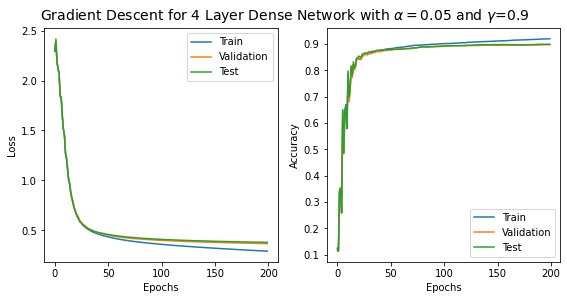

In [22]:
title = r"Gradient Descent for 4 Layer Dense Network with $\alpha={}$ and $\gamma$={}".format(0.05, 0.90)
plot_learning_history(title, four_lyr_loss_hist, four_lyr_accuracy_hist)